# Week4

## 1. Load and imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import octis
from tqdm import tqdm_notebook
from tqdm import tqdm

tqdm.pandas()
tqdm_notebook().pandas()

/var/folders/n1/2dp16v113lv8x5rwt1t69_v40000gn/T/ipykernel_1158/2568179296.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
df_cond = pd.read_csv('./../../Data/Dataframes/df_condorcet_processed.csv')

## 2. Pre-Processing

### a. Removing Side info

In [4]:
df_cond['Side_Info'] = df_cond['Eloge'].apply(lambda x : re.findall('\[(.*?)\]', x))

In [5]:
df_cond['Eloge'] = df_cond['Eloge'].apply(lambda x : re.sub('\[(.*?)\]','', x))

### b. Removing \n, \t, non useful spaces

In [6]:
df_cond['Eloge'] = df_cond['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

### c. Removing punctuations

In [7]:
df_cond['Eloge_no_punkt'] = df_cond['Eloge'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))


### d. Removing stop-words and words smaller than 2

In [8]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.corpus import stopwords

stop_words =set(stopwords.words('french'))

fr_stop.update({'plus', 'ce', 'cette', 'encore', 'alors'})

print('Number of stop-words in spacy : ' + str(len(fr_stop)))
print('Number of stop-words in nltk : ' + str(len(stop_words)))


Number of stop-words in spacy : 507
Number of stop-words in nltk : 157


In [9]:
df_cond['Eloge_no_sw_no_punkt'] = df_cond['Eloge_no_punkt'].apply(lambda x : " ".join([i for i in x.split() if 
                                                                             (i not in fr_stop and len(i)>2)]))


### e. Stemming and lemmatizing

In [10]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

df_cond['Eloge_stem'] = df_cond['Eloge_no_sw_no_punkt'].progress_apply(lambda x : [stemmer.stem(word) for word in
                                                                         x.split()])

In [11]:
import spacy
nlp = spacy.load("fr_core_news_sm")

tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr', TAGDIR = './../Treetagger')

df_cond['Eloge_lem'] = df_cond['Eloge_no_sw_no_punkt'].progress_apply(lambda x : [token

### f. Remove numbers

In [12]:
df_cond['Eloge_stem'] = df_cond['Eloge_stem'].apply(lambda x : ' '.join([i for i in x if not i.isdigit()]))

df_cond['Eloge_lem'] = df_cond['Eloge_lem'].apply(lambda x : ' '.join([i for i in x if not i.isdigit()]))

## 3. Topic Modelling

In [13]:
from gensim.models import Phrases

df_cond['tokens'] = df_cond['Eloge_lem'].progress_apply(lambda x : x.split())

In [14]:
#adding bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = nltk.collocations.BigramCollocationFinder.from_documents([x.split() for x in df_cond['Eloge_lem']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [15]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [16]:
import nltk
nltk.download('averaged_perceptron_tagger')
# Example filter for noun-type structures bigrams

def bigram_filter(bigram):
    if bigram[0] in fr_stop or bigram[1] in fr_stop:
        return False
    return True
# Can eyeball list and choose PMI threshold where n-grams stop making sense
# In this case, get top 500 bigrams/trigrams with highest PMI score
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram_filter(bigram['bigram'])and bigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/clemencebarsi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
bigrams[:10]


['histoire naturel', 'petit nombre', 'grand nombre', 'académie science']

In [18]:
def replace_ngram(x):
   # for gram in trigrams:
   #x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = df_cond.copy()

reviews_1776 = df_cond[df_cond['Annee']<1776]

reviews_1789 = df_cond[(df_cond['Annee']>=1776)|(df_cond['Annee']<1789)]

reviews_1791 = df_cond[(df_cond['Annee']>=1789)]

reviews_w_ngrams.Eloge_lem = reviews_w_ngrams.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_w_ngrams = reviews_w_ngrams.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])

reviews_1776.Eloge_lem = reviews_1776.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_1776 = reviews_1776.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])
reviews_1789.Eloge_lem = reviews_1789.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_1789 = reviews_1789.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])
reviews_1791.Eloge_lem = reviews_1791.Eloge_lem.map(lambda x: replace_ngram(x))

reviews_1791 = reviews_1791.Eloge_lem.map(lambda x: [word for word in x.split() if word not in fr_stop 
                                                         and len(word) > 2])

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)

final_1776 = reviews_1776.map(noun_only)

final_1789 = reviews_1789.map(noun_only)

final_1791 = reviews_1791.map(noun_only)



In [20]:
import gensim

dictionary = gensim.corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


In [21]:
coherence = []
for k in tqdm(range(1,25)):
    #print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

100%|███████████████████████████████████████████| 24/24 [04:12<00:00, 10.54s/it]


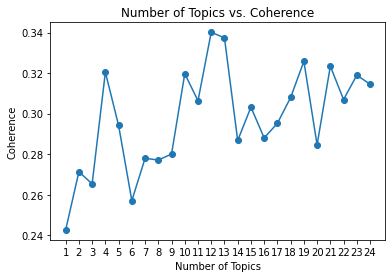

In [22]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [23]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=14, id2word = dictionary, passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [24]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

topic_data =  pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

## 4. Les éloges commencent par la naissance

In [25]:
new_df = df_cond.copy()
new_df = new_df[['Savant', 'Annee', 'Eloge', 'Side_Info', 'Eloge_lem']]

In [26]:
new_df['First_Sent'] = new_df['Eloge'].apply(lambda x : x.split('.')[0])
new_df

,Savant,Annee,Eloge,Side_Info,Eloge_lem,First_Sent
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",[],Marin cureau chambre médecin ordinaire roi naî...,"Marin Cureau de la Chambre, médecin ordinaire ..."
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",[],Nicolas Frenicle Bessy conseiller cour monnaie...,"Nicolas Frenicle de Bessy, conseiller à la cou..."
2,Picard,1773,L’abbé Picard naquit dans un temps où Kepler e...,[],abbé Picard naquit temps Kepler galiler venir ...,L’abbé Picard naquit dans un temps où Kepler e...
3,Mariotte,1773,"Edme Mariotte naquit à Dijon, ou du moins il y...",[],Edme mariotte naître Dijon passa partie vie di...,"Edme Mariotte naquit à Dijon, ou du moins il y..."
4,Duclos,1773,"Samuel Cotreau Duclos, médecin ordinaire du ro...",[],Samuel Cotreau Duclos médecin ordinaire roi êt...,"Samuel Cotreau Duclos, médecin ordinaire du ro..."
...,...,...,...,...,...,...
61,Fougeroux,1789,"Auguste Denis Fougeroux, de l’Institut de Bolo...",[],Auguste Denis Fougeroux Institut Bologne socié...,"Auguste Denis Fougeroux, de l’Institut de Bolo..."
62,de Fourcroy,1791,"Charles-René de Fourcroy, maréchal de camp, gr...",[],Charles René Fourcroy maréchal camp grand croi...,"Charles-René de Fourcroy, maréchal de camp, gr..."
63,Turgot,1789,"Étienne-François Turgot, associé libre de l’Ac...",[],Étienne François Turgot associer libre académi...,"Étienne-François Turgot, associé libre de l’Ac..."
64,de L'Hôpital,1777,Chancelier de France. Discours présenté à L’ac...,[],Chancelier France discours présenter académie ...,Chancelier de France


In [27]:
ls = ['naquit','naitre', 'né']

def check_naissance(string):
    for word in ls:
        if word in string:
            return True
    return False

In [28]:
new_df['naissance'] = new_df['Eloge'].progress_apply(lambda x : check_naissance(x))

In [29]:
new_df[new_df['naissance']==False]

,Savant,Annee,Eloge,Side_Info,Eloge_lem,First_Sent,naissance
19,Bianchi,1773,"Il est mort en 1760, âgé de quatre-vingts ans,...",[],mort âgé vingts an professer médecine Turin an...,"Il est mort en 1760, âgé de quatre-vingts ans,...",False


In [30]:
new_df.loc[19, 'First_Sent']

'Il est mort en 1760, âgé de quatre-vingts ans, après avoir professé la médecine à Turin pendant quarante-cinq ans'

All the eulogies start with a statement on the birth

## 5. Synsets

In [34]:
#https://stackoverflow.com/questions/59198008/how-to-find-all-synoyms-for-a-french-word-using-nltk
#

from nltk.corpus import wordnet as wn
from nltk.wsd import lesk


list_pos = ['pleurer', 'malheur', 'martyr', 'tendresse', 'sensibilité', 'douceur touchante', 'reconnaissance', 'reconnoissance']
list_neg = ['ignorance', 'cupidité', 'égoïsme', 'bigoterie', 'frivolité', 'clanisme', 'envie', 'oisiveté', 'privilège', 'vanité']


In [35]:
set_pos = set()
set_neg = set()


        
for word in list_pos:
    set_pos.add(word)
    for ss in [n for synset in wn.synsets(word, lang = 'fra') for n in synset.lemma_names('fra')]:
        set_pos.add(ss)

for word in list_neg:
    set_neg.add(word)
    for ss in [n for synset in wn.synsets(word, lang = 'fra') for n in synset.lemma_names('fra')]:
        set_neg.add(ss)

In [36]:
set_pos.add('pleurs')
set_pos.add('pleure')

In [37]:

new_df['list_pos'] = new_df['Eloge'].apply(lambda x : list(set([i for i in set_pos if i in x])))
new_df['list_neg'] = new_df['Eloge'].apply(lambda x : list(set([i for i in set_neg if i in x])))


In [38]:
new_df.head(10)

,Savant,Annee,Eloge,Side_Info,Eloge_lem,First_Sent,naissance,list_pos,list_neg
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",[],Marin cureau chambre médecin ordinaire roi naî...,"Marin Cureau de la Chambre, médecin ordinaire ...",True,"[reconnaissance, ingratitude, cri, gratitude, ...","[honneur, vanité, avantage, envie, faveur]"
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",[],Nicolas Frenicle Bessy conseiller cour monnaie...,"Nicolas Frenicle de Bessy, conseiller à la cou...",True,"[amour, cri, crédit, abord]",[honneur]
2,Picard,1773,L’abbé Picard naquit dans un temps où Kepler e...,[],abbé Picard naquit temps Kepler galiler venir ...,L’abbé Picard naquit dans un temps où Kepler e...,True,"[abord, reconnaissance]",[avantage]
3,Mariotte,1773,"Edme Mariotte naquit à Dijon, ou du moins il y...",[],Edme mariotte naître Dijon passa partie vie di...,"Edme Mariotte naquit à Dijon, ou du moins il y...",True,"[reconnaissance, cri, amour, malheur, crédit]",[ignorance]
4,Duclos,1773,"Samuel Cotreau Duclos, médecin ordinaire du ro...",[],Samuel Cotreau Duclos médecin ordinaire roi êt...,"Samuel Cotreau Duclos, médecin ordinaire du ro...",True,[amour],[avarice]
5,Blondel,1773,"François Blondel naquit à Ribemont, en Picardi...",[],François Blondel naître Ribemont Picardie Sait...,"François Blondel naquit à Ribemont, en Picardi...",True,"[reconnaissance, tendance, cri, affection, abo...","[ignorance, envie, honneur, faveur]"
6,Huygens,1773,"Christian Huygens naquit à la Haye, le 14 avri...",[],Christian Huygens naître Haye avril Constantin...,"Christian Huygens naquit à la Haye, le 14 avri...",True,"[reconnaissance, tendance, cri, accident, iden...","[envie, honneur, avantage]"
7,Charas,1773,"Moïse Charas naquit à Usez vers 1618, d’une fa...",[],Moïse Charas naître Usez famill protestant éta...,"Moïse Charas naquit à Usez vers 1618, d’une fa...",True,"[amour, cri, crédit, abord]","[ignorance, honneur, vanité, faveur]"
8,Roëmer,1773,Souvent l’observation d’un phénomène suffit po...,[],souvent observation phénomèn immortel nom aute...,Souvent l’observation d’un phénomène suffit po...,True,"[reconnaissance, cri, abord, amour, malheur]","[envie, honneur]"
9,Rohaut,1773,"Au sortir du collège, où l’on n’enseignait enc...",[],sortir collège enseigner péripatétisme être at...,"Au sortir du collège, où l’on n’enseignait enc...",True,[cri],[]


Text(0, 0.5, 'Number of eulogies appearing in')

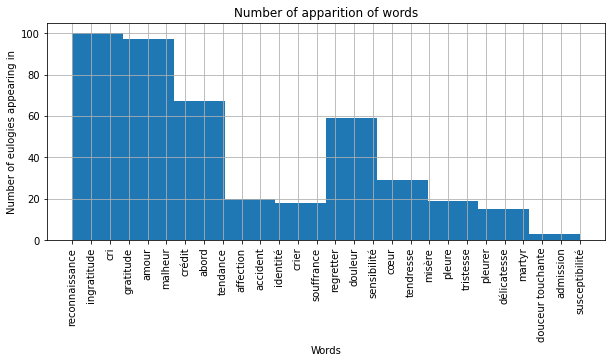

In [39]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from pandas import Series
new_df['list_pos'].apply(Series).stack().hist(figsize = (10, 4), xrot = 90)
plt.title('Number of apparition of words')
plt.xlabel('Words')
plt.ylabel('Number of eulogies appearing in')

Text(0, 0.5, 'Number of eulogies appearing ing')

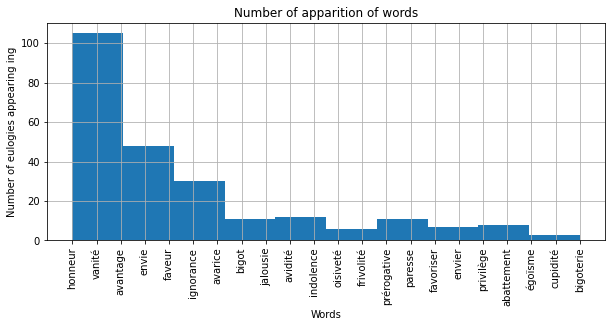

In [40]:

new_df['list_neg'].apply(Series).stack().hist(figsize = (10, 4), xrot = 90)
plt.title('Number of apparition of words')
plt.xlabel('Words')
plt.ylabel('Number of eulogies appearing ing')

## 6. Part Of Speech

In [41]:
import pprint
import treetaggerwrapper

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [42]:
tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr', TAGDIR = './../Treetagger')

In [43]:
tags = tagger.tag_text('Ceci est un test')
pprint.pprint(tags)

['Ceci\tPRO:DEM\tceci',
 'est\tVER:pres\têtre',
 'un\tDET:ART\tun',
 'test\tNOM\ttest']


In [44]:
df_cond['tags'] = df_cond['Eloge'].progress_apply(lambda x : tagger.tag_text(x))

In [45]:
df_cond['tags'] = df_cond['tags'].progress_apply(lambda x : treetaggerwrapper.make_tags(x))

In [46]:
df_cond.to_csv('./../../Data/Dataframes/df_cond_tags.csv', index = False)

In [47]:
df_cond['list_of_tags'] = df_cond['tags'].progress_apply(lambda x : [elem[1] for elem in x if len(elem)>2])


In [105]:
df_cond['Eloge_lem'] = df_cond['tags'].progress_apply(lambda x : ' '.join([elem[2] for elem in x if len(elem)>2]))

In [48]:
pos_tags = pd.read_csv('./../../Data/POS-tags.csv', header=None, index_col=0, squeeze=True).to_dict()
print(pos_tags)

{'ABR': 'abbreviation', 'ADJ': 'adjective', 'ADV': 'adverb', 'DET:ART': 'article', 'DET:POS': 'possessive pronoun (ma, ta, ...)', 'INT': 'interjection', 'KON': 'conjunction', 'NAM': 'proper name', 'NOM': 'noun', 'NUM': 'numeral', 'PRO': 'pronoun', 'PRO:DEM': 'demonstrative pronoun', 'PRO:IND': 'indefinite pronoun', 'PRO:PER': 'personal pronoun', 'PRO:POS': 'possessive pronoun (mien, tien, ...)', 'PRO:REL': 'relative pronoun', 'PRP': 'preposition', 'PRP:det': 'preposition plus article (au,du,aux,des)', 'PUN': 'punctuation', 'PUN:cit': 'punctuation citation', 'SENT': 'sentence tag', 'SYM': 'symbol', 'VER:cond': 'verb conditional', 'VER:futu': 'verb futur', 'VER:impe': 'verb imperative', 'VER:impf': 'verb imperfect', 'VER:infi': 'verb infinitive', 'VER:pper': 'verb past participle', 'VER:ppre': 'verb present participle', 'VER:pres': 'verb present', 'VER:simp': 'verb simple past', 'VER:subi': 'verb subjunctive imperfect', 'VER:subp': 'verb subjunctive present'}


In [49]:
df_cond['list_of_tags'] = df_cond['list_of_tags'].apply(lambda x : [pos_tags[elem] for elem in x])

Text(0, 0.5, "Nombre d'apparition")

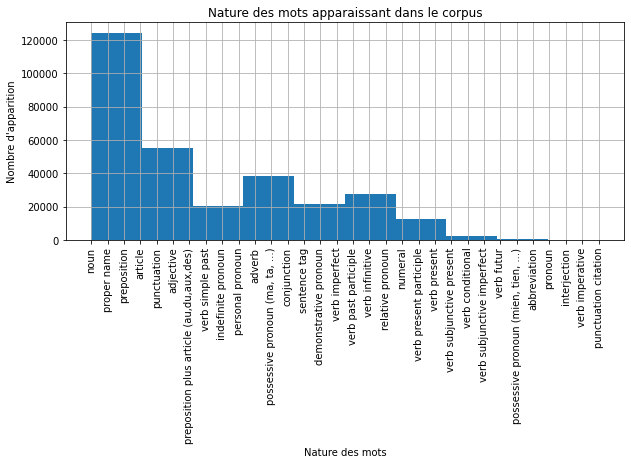

In [50]:
#plt.xticks(rotation='vertical')
df_cond['list_of_tags'].apply(Series).stack().hist(figsize = (10,4), xrot = 90)
plt.title('Nature des mots apparaissant dans le corpus')
plt.xlabel('Nature des mots')
plt.ylabel("Nombre d'apparition")

## 7. Negative Matrix Factorization

In [51]:
#https://predictivehacks.com/topic-modelling-with-nmf-in-python/

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50)
 
# Fit and transform
X = vect.fit_transform(df_cond.Eloge_lem)

In [53]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=10, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [54]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,académie,an,art,aucun,avoir,bien,ce,chercher,connaissance,connaître,...,science,temps,travail,trop,trouver,utile,voir,vouloir,état,être
0,0.128955,0.068647,0.000000,0.018746,0.469516,0.200085,0.106096,0.110831,0.076357,0.000000,...,0.294648,0.000000,0.001154,0.177015,0.000000,0.202283,0.070736,0.080864,0.226056,0.922997
1,0.738834,0.287849,0.328310,0.000000,0.000000,0.000000,0.000000,0.007729,0.000000,0.000000,...,0.000000,0.064016,0.000000,0.288125,0.000000,0.297276,0.091360,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.119272,0.069969,0.018771,0.242572,0.212385,0.000000,0.073591,0.000000,...,0.000000,0.004582,0.000000,0.000000,0.167819,0.000000,0.447222,0.000000,0.028771,0.049954
3,0.283421,0.054397,0.067967,0.000000,0.055439,0.030362,0.000000,0.049166,0.032630,0.015901,...,0.982974,0.080417,0.167887,0.000000,0.004087,0.025837,0.016437,0.000000,0.107847,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.074753,0.296348,0.038084,0.043650,0.374684,...,0.065597,0.381840,0.051845,0.073148,0.150142,0.000000,0.000000,0.107407,0.007990,0.000000
5,0.000000,0.000000,0.014761,0.122078,0.120009,0.135538,0.058688,0.182130,0.000000,0.053255,...,0.091354,0.000000,0.000604,0.220826,0.000000,0.044542,0.280395,0.257200,0.278522,0.484871
6,0.000000,0.073268,0.429838,0.175415,0.000000,0.133299,0.125385,0.000000,0.077625,0.094092,...,0.000000,0.682653,0.000000,0.007703,0.272451,0.111081,0.000000,0.169138,0.000000,0.302983
7,0.000000,0.340666,0.000000,0.016392,0.487504,0.000000,0.056473,0.050093,0.023767,0.000000,...,0.010028,0.000000,0.000000,0.008547,0.167007,0.129243,0.000000,0.319134,0.000000,0.276895
8,0.032573,0.000000,0.000000,0.100710,0.000000,0.391386,0.000000,0.032933,0.243902,0.169507,...,0.042328,0.000000,0.000000,0.115120,0.077122,0.083052,0.311926,0.000000,0.000000,0.184319
9,0.143900,0.000000,0.000000,0.120390,0.000000,0.000000,0.140734,0.089936,0.009125,0.274428,...,0.109719,0.083038,0.799799,0.000000,0.054409,0.033526,0.241958,0.000000,0.000000,0.708175


In [55]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
être       0.922997
nouveau    0.519007
avoir      0.469516
faire      0.396746
devoir     0.305238
science    0.294648
état       0.226056
le         0.224202
esprit     0.212553
objet      0.211405
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
académie       0.738834
art            0.328310
observation    0.321269
mort           0.306383
utile          0.297276
important      0.288519
trop           0.288125
an             0.287849
nombre         0.260091
grand          0.240485
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
observation    0.785459
voir           0.447222
petit          0.349317
bien           0.242572
ce             0.212385
faire          0.173454
grand          0.171487
trouver        0.167819
nature         0.160315
nombre         0.138072
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
science     0.982974
presque     0.445796


## In 1773

In [56]:
warnings.simplefilter("ignore", DeprecationWarning)


# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer()
 
df_1773 = df_cond[df_cond['Annee'] ==1773]
# Fit and transform
X = vect.fit_transform(df_1773.Eloge_lem)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=4, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
être           0.287745
observation    0.244022
flamstead      0.224722
picard         0.219266
bartholin      0.215951
faire          0.187956
astronome      0.186537
animal         0.181812
peyssonnel     0.171631
voir           0.165912
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
roberval     0.187559
problème     0.171546
huygens      0.171438
frenicle     0.160925
descartes    0.150100
ami          0.145502
pèr          0.144608
être         0.141397
méthode      0.134241
courbe       0.115919
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
professer       0.185921
médecine        0.152740
an              0.140425
pratique        0.130646
forme           0.124325
ouvrage         0.117152
heureux         0.116550
chirurgicale    0.107793
concitoyen      0.107793
couronné        0.107793
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
expérience  

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## In 1780

In [57]:
warnings.simplefilter("ignore", DeprecationWarning)


# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer()
 
df_1773 = df_cond[df_cond['Annee'] ==1780]
# Fit and transform
X = vect.fit_transform(df_1773.Eloge_lem)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=4, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
lieutaud       2.819283
médecin        1.191029
être           1.191029
science        0.940286
observation    0.877600
faire          0.877600
homme          0.877600
bien           0.877600
ouvrage        0.814914
aix            0.704821
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
bucquet      1.224720
science      0.833495
être         0.568603
étude        0.513532
analyse      0.509666
chimie       0.498178
devoir       0.487439
grand        0.483370
substance    0.479652
homme        0.458708
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
bucquet       0.459648
moyen         0.281582
cours         0.244053
métallique    0.224679
analyse       0.218244
air           0.212442
organique     0.204998
travail       0.202598
imprimé       0.198559
alcali        0.196966
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
bucquet      1.283847
analyse   

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


## In 1789

In [58]:
warnings.simplefilter("ignore", DeprecationWarning)


# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer()
 
df_1789 = df_cond[df_cond['Annee'] ==1789]
# Fit and transform
X = vect.fit_transform(df_1773.Eloge_lem)

# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=4, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
lieutaud       2.819283
médecin        1.191029
être           1.191029
science        0.940286
observation    0.877600
faire          0.877600
homme          0.877600
bien           0.877600
ouvrage        0.814914
aix            0.704821
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
bucquet      1.224720
science      0.833495
être         0.568603
étude        0.513532
analyse      0.509666
chimie       0.498178
devoir       0.487439
grand        0.483370
substance    0.479652
homme        0.458708
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
bucquet       0.459648
moyen         0.281582
cours         0.244053
métallique    0.224679
analyse       0.218244
air           0.212442
organique     0.204998
travail       0.202598
imprimé       0.198559
alcali        0.196966
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
bucquet      1.283847
analyse   

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


## 8. Most frequent words over time

In [59]:
#Most frequent words
# https://stackoverflow.com/questions/29903025/count-most-frequent-100-words-from-sentences-in-dataframe-pandas
from collections import Counter
Counter(" ".join(df_cond["Eloge_stem"]).split()).most_common(100)

[('homm', 1099),
 ('grand', 699),
 ('scienc', 669),
 ('don', 594),
 ('été', 594),
 ('fut', 538),
 ('part', 496),
 ('bien', 487),
 ('point', 483),
 ('fair', 482),
 ('ouvrag', 462),
 ('observ', 460),
 ('vérit', 446),
 ('util', 433),
 ('temp', 431),
 ('trouv', 401),
 ('forc', 371),
 ('sav', 362),
 ('form', 348),
 ('sent', 346),
 ('natur', 342),
 ('esprit', 342),
 ('vi', 333),
 ('academ', 332),
 ('objet', 328),
 ('plac', 319),
 ('méthod', 319),
 ('le', 305),
 ('occup', 305),
 ('trop', 299),
 ('médecin', 289),
 ('franc', 288),
 ('philosoph', 287),
 ('regard', 282),
 ('lois', 282),
 ('nouvel', 279),
 ('général', 279),
 ('princip', 277),
 ('eût', 275),
 ('mérit', 274),
 ('jam', 269),
 ('emploi', 267),
 ('gloir', 266),
 ('idé', 265),
 ('nombr', 257),
 ('état', 256),
 ('peupl', 251),
 ('presqu', 245),
 ('raison', 245),
 ('art', 244),
 ('naturel', 244),
 ('cherch', 241),
 ('découvert', 240),
 ('connaiss', 239),
 ('livr', 238),
 ('gen', 234),
 ('aucun', 234),
 ('moyen', 233),
 ('dev', 229),
 ('co

<AxesSubplot:xlabel='word'>

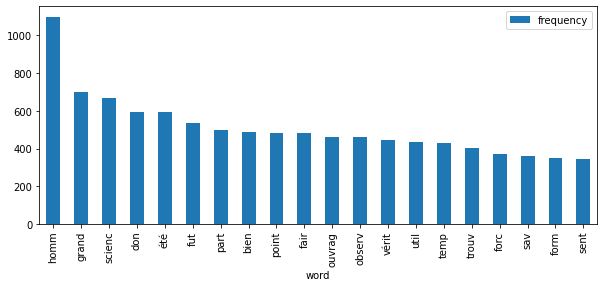

In [60]:
count_stem = Counter(" ".join(df_cond["Eloge_stem"]).split()).most_common(20)
df = pd.DataFrame(count_stem, columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize = (10,4))

<AxesSubplot:xlabel='word'>

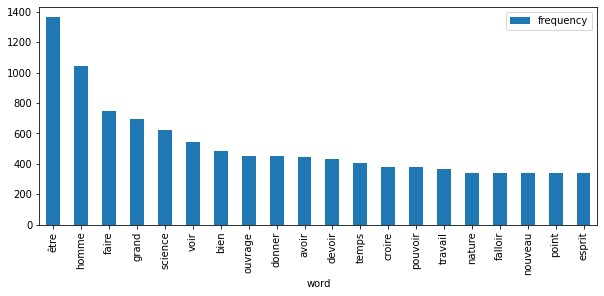

In [61]:
count_lem = Counter(" ".join(df_cond["Eloge_lem"]).split()).most_common(20)
df = pd.DataFrame(count_lem, columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize = (10,4))

In [62]:
count_25 = Counter(" ".join(df_cond["Eloge_stem"]).split()).most_common(25)
most_25 = [elem[0] for elem in count_25]

In [63]:
most_25

['homm',
 'grand',
 'scienc',
 'don',
 'été',
 'fut',
 'part',
 'bien',
 'point',
 'fair',
 'ouvrag',
 'observ',
 'vérit',
 'util',
 'temp',
 'trouv',
 'forc',
 'sav',
 'form',
 'sent',
 'natur',
 'esprit',
 'vi',
 'academ',
 'objet']

In [64]:
most_25.pop(most_25.index('été'))
most_25.pop(most_25.index('fut'))


'fut'

In [65]:
def agg_func(ls, word = most_25):
    count = {}
    for w in word:
        count[w] = 0
    for st in ls :
        for w in word:
            count[w] += st.count(w)
    return count

group = df_cond.groupby('Annee').agg({'Eloge_stem' : agg_func, 'Auteur' : 'count'}).rename(columns ={'Eloge_stem' : 'Count_Words', 
                                                                                            'Auteur':'Count'}).reset_index()

In [66]:
group = pd.concat([group, group['Count_Words'].apply(pd.Series)], axis=1)
group.drop('Count_Words', axis=1, inplace = True)
group.drop('Count', axis=1, inplace = True)
pd.set_option('display.max_columns', 500)

Text(0, 0.5, 'Number of appearance')

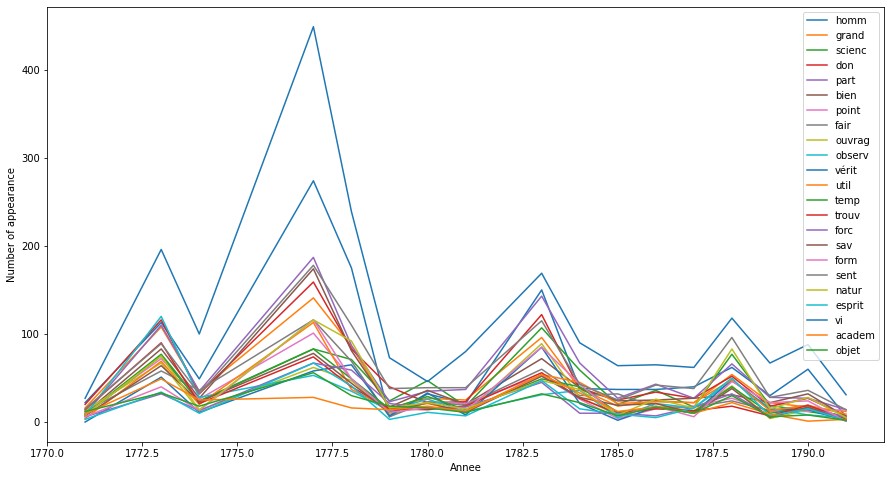

In [67]:
fig, ax = plt.subplots(figsize = (15,8))

for word in most_25:
    ax = group.plot(ax=ax, kind='line', x='Annee', y=word) 
plt.ylabel('Number of appearance')


In [68]:
def norm(dic, norm):
    for key, val in dic.items():
        dic[key] = val/norm
    return key

group_norm = df_cond.groupby('Annee').agg({'Eloge_stem' : agg_func, 'Auteur' : 'count'}).rename(columns ={'Eloge_stem' : 'Count_Words', 
                                                                                            'Auteur':'Count'}).reset_index()
group_norm['Count_words'] = group_norm.apply(lambda x : norm(x['Count_Words'], x['Count']) , axis = 1)


group_norm = pd.concat([group_norm, group_norm['Count_Words'].apply(pd.Series)], axis=1)
group_norm.drop('Count_Words', axis=1, inplace = True)
group_norm.drop('Count', axis=1, inplace = True)
pd.set_option('display.max_columns', 500)
group_norm

,Annee,Count_words,homm,grand,scienc,don,part,bien,point,fair,ouvrag,observ,vérit,util,temp,trouv,forc,sav,form,sent,natur,esprit,vi,academ,objet
0,1771,objet,22.000000,16.000000,9.000000,20.000000,9.000000,10.000000,10.000000,12.000000,13.000000,8.000000,0.000000,4.000000,8.000000,14.000000,6.000000,7.000000,6.000000,15.000000,8.000000,3.000000,27.000000,9.000000,12.00
1,1773,objet,4.520000,4.320000,3.080000,4.640000,4.400000,3.320000,2.880000,2.320000,2.680000,4.800000,2.040000,2.760000,3.000000,3.600000,1.280000,2.560000,1.600000,3.560000,3.000000,1.360000,7.840000,1.960000,1.32
2,1774,objet,49.000000,35.000000,24.000000,32.000000,35.000000,27.000000,26.000000,36.000000,13.000000,28.000000,11.000000,20.000000,23.000000,21.000000,13.000000,23.000000,13.000000,32.000000,14.000000,10.000000,100.000000,25.000000,18.00
3,1777,objet,54.800000,28.200000,16.600000,31.800000,37.400000,34.800000,20.200000,23.200000,12.400000,10.600000,11.600000,22.600000,16.600000,14.800000,13.400000,15.600000,23.200000,35.600000,23.200000,13.400000,89.800000,5.600000,11.20
4,1778,objet,58.333333,28.666667,23.666667,27.666667,29.000000,27.000000,16.333333,23.000000,15.666667,11.666667,21.666667,12.333333,16.333333,13.333333,19.666667,14.666667,16.333333,36.666667,30.666667,13.666667,79.666667,5.333333,10.00
5,1779,objet,3.000000,8.000000,12.000000,20.000000,11.500000,8.500000,6.000000,3.000000,4.500000,6.500000,3.500000,7.500000,7.500000,7.500000,10.500000,5.500000,5.500000,19.000000,8.000000,1.500000,36.500000,7.000000,9.00
6,1780,objet,16.000000,13.500000,23.500000,11.000000,17.500000,18.000000,11.500000,11.500000,11.000000,13.000000,16.500000,10.500000,14.500000,7.000000,8.000000,11.000000,8.000000,19.500000,11.000000,5.500000,23.000000,9.000000,8.00
7,1781,objet,10.500000,12.500000,9.000000,11.500000,18.500000,10.000000,10.500000,9.500000,5.000000,6.000000,4.000000,6.000000,7.000000,9.000000,8.500000,5.500000,6.500000,19.500000,7.500000,3.500000,40.000000,6.000000,5.50
8,1783,objet,30.000000,19.200000,21.400000,24.400000,28.600000,14.400000,10.600000,12.000000,17.800000,6.200000,17.000000,10.800000,9.800000,11.200000,9.000000,10.400000,17.000000,23.000000,9.400000,9.400000,33.800000,10.800000,6.40
9,1784,objet,7.600000,7.600000,11.800000,7.400000,13.400000,7.800000,5.200000,6.000000,5.600000,7.200000,4.200000,9.000000,8.000000,5.400000,2.000000,5.600000,8.600000,8.600000,7.400000,3.000000,18.000000,6.600000,4.40


Text(0, 0.5, 'Number of appearance normed by the number of eulogies this year')

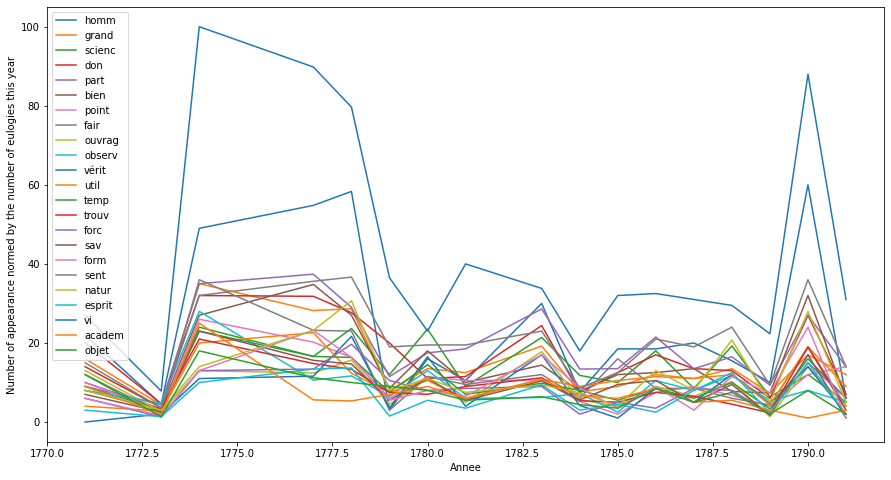

In [69]:
fig, ax = plt.subplots(figsize = (15,8))

for word in most_25:
    ax = group_norm.plot(ax=ax, kind='line', x='Annee', y=word) 
plt.ylabel('Number of appearance normed by the number of eulogies this year')

## 9. Bertopic

In [70]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer


In [71]:
# Prepare embeddings
sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens")

docs = df_cond.Eloge_lem
embeddings = sentence_model.encode(docs, show_progress_bar=False)

# Create topic model
model = BERTopic(language ='French')
topics, probabilities = model.fit_transform(docs, embeddings)

# 10. Information Extraction

## a. République

In [72]:
df_cond['République'] = df_cond['Eloge'].progress_apply(lambda x : [sent for sent in x.split('.') 
                                                                    if (('République' in sent) or ('république' in sent) or ('republique' in sent))])

In [73]:
subdf = df_cond[df_cond.République.astype(bool)].copy()


In [74]:
for _, row in subdf.iterrows():
    for sent in row['République']:
        print(sent)

 Il avait été employé au conclave qui élut innocent X, et auprès de la république de Gènes    *************** <Essai d’une Histoire des correspondances de l'Académie royale des sciences>  Obligé, par reconnaissance et par devoir, de consacrer mon temps à l’Académie, je vais soumettre à son jugement quelques essais d’un travail qui, par son objet du moins, m’a paru n’être pas indigne de son attention : c’est une histoire de ses correspondants
 Pour établir une république d’Amazones et la perpétuer, il faudrait un système de législation si compliqué, que ce n’est pas chez des sauvages que l’on pourrait trouver un peuple de femmes
Albert de Haller, membre du conseil souverain de Berne, président de la société économique de la même ville, et de l’Académie de Gottingue, associé étranger de l’Académie des Sciences de Paris, et de presque toutes les autres sociétés savantes de l’Europe , naquit à Berne, le 18 octobre 1708, de Nicolas de Haller, avocat et chancelier du comté de Baden, d’une an

## b. Valeurs de la République des Sciences

In [75]:
val = ['vérité', 'raison', 'talent', 'transmission', 'savoir', 'osbservation', 'expérience','élite',
      'république', 'égalité', 'universelle', 'lumières', 'savant', 'œuvre', 'oeuvre', 'plan', 'réunion', 'commun', 'science',
      'progrès', 'ouvrage', 'république']
valeurs = []

for word in val :
    if not word.endswith('s'):
        valeurs.append(word+'s')
    valeurs.append(word.capitalize())
    valeurs.append((word+'s').capitalize())
    valeurs.append(word)
valeurs

['vérités',
 'Vérité',
 'Vérités',
 'vérité',
 'raisons',
 'Raison',
 'Raisons',
 'raison',
 'talents',
 'Talent',
 'Talents',
 'talent',
 'transmissions',
 'Transmission',
 'Transmissions',
 'transmission',
 'savoirs',
 'Savoir',
 'Savoirs',
 'savoir',
 'osbservations',
 'Osbservation',
 'Osbservations',
 'osbservation',
 'expériences',
 'Expérience',
 'Expériences',
 'expérience',
 'élites',
 'Élite',
 'Élites',
 'élite',
 'républiques',
 'République',
 'Républiques',
 'république',
 'égalités',
 'Égalité',
 'Égalités',
 'égalité',
 'universelles',
 'Universelle',
 'Universelles',
 'universelle',
 'Lumières',
 'Lumièress',
 'lumières',
 'savants',
 'Savant',
 'Savants',
 'savant',
 'œuvres',
 'Œuvre',
 'Œuvres',
 'œuvre',
 'oeuvres',
 'Oeuvre',
 'Oeuvres',
 'oeuvre',
 'plans',
 'Plan',
 'Plans',
 'plan',
 'réunions',
 'Réunion',
 'Réunions',
 'réunion',
 'communs',
 'Commun',
 'Communs',
 'commun',
 'sciences',
 'Science',
 'Sciences',
 'science',
 'Progrès',
 'Progrèss',
 'progrès',

In [76]:
df_cond['Valeurs'] = df_cond['Eloge'].progress_apply(lambda x : [sent for sent in x.split('.') if any(s in sent for s in valeurs)])    

In [77]:
df_val = df_cond[['Savant', 'Annee', 'Eloge', 'Valeurs']].copy()

In [78]:
import spacy
nlp = spacy.load("fr_core_news_sm")

df_val['Valeurs'] = df_val['Valeurs'].progress_apply(lambda x : ' '.join(x))
df_val['processed'] = df_val['Valeurs'].progress_apply(lambda x : re.sub(r'[^\w\s]', ' ', x))
df_val['processed'] = df_val['processed'].progress_apply(lambda x : ' '.join([w for w in x.split() if (w not in fr_stop and len(w)>2)]))
df_val['processed'] = df_val['processed'].progress_apply(lambda x : ' '.join([i for i in x.split(' ') if not i.isdigit()]))
df_val['processed'] = df_val['processed'].progress_apply(lambda x : ' '.join([token.lemma_ for token in nlp(x)]))



In [79]:
df_val.head()

,Savant,Annee,Eloge,Valeurs,processed
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",Il était bien éloigné de dédaigner les Scienc...,bien éloigner dédaigner science fortun espèce ...
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",On trouve un grand nombre de magistrats dans...,trouve grand nombre magistrat list savant âg i...
2,Picard,1773,L’abbé Picard naquit dans un temps où Kepler e...,Des théories plus vraies faisaient sentir ce ...,un théorie vraie sentir manquer partie pratiqu...
3,Mariotte,1773,"Edme Mariotte naquit à Dijon, ou du moins il y...",C’est de Dijon qu’il a daté plusieurs de ses ...,dijon dater ouvrage prouve nerf optique organ ...
4,Duclos,1773,"Samuel Cotreau Duclos, médecin ordinaire du ro...",Des hommes pleins de génie et d’idées chimér...,un homme plein génie idée chimérique cultivé c...


In [80]:
import gensim


final_reviews = df_val.processed.apply(lambda x : x.split())
dictionary = gensim.corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


In [81]:
coherence = []
for k in tqdm(range(1,25)):
    #print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

  0%|                                                    | 0/24 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  4%|█▊                                          | 1/24 [00:09<03:30,  9.16s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  8%|███▋                                        | 2/24 [00:16<03:11,  8.69s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 12%|█████▌                                      | 3/24 [00:24<02:56,  8.41s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 12%|█████▌                                      | 3/24 [00:29<03:27,  9.90s/it]/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/clemencebarsi/miniconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_s

KeyboardInterrupt: 

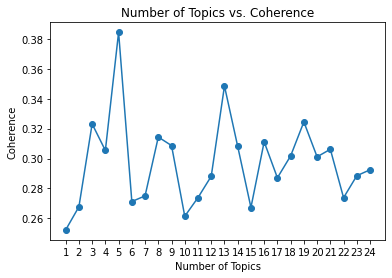

In [184]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [187]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [188]:
pyLDAvis.enable_notebook()

topic_data =  pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'mmds')
pyLDAvis.display(topic_data)

In [190]:
ldamodel.show_topics()

[(0,
  '0.011*"science" + 0.008*"être" + 0.007*"homme" + 0.007*"ouvrage" + 0.006*"grand" + 0.006*"faire" + 0.005*"plante" + 0.004*"voir" + 0.004*"bien" + 0.004*"utile"'),
 (1,
  '0.011*"homme" + 0.007*"être" + 0.006*"peuple" + 0.006*"raison" + 0.005*"grand" + 0.005*"loi" + 0.005*"faire" + 0.005*"lumière" + 0.004*"voir" + 0.004*"nation"'),
 (2,
  '0.009*"être" + 0.008*"plante" + 0.008*"ouvrage" + 0.007*"science" + 0.006*"homme" + 0.006*"nature" + 0.005*"savant" + 0.005*"Jussieu" + 0.005*"voir" + 0.005*"grand"'),
 (3,
  '0.015*"science" + 0.010*"ouvrage" + 0.009*"homme" + 0.009*"être" + 0.006*"faire" + 0.006*"grand" + 0.005*"savant" + 0.004*"donner" + 0.004*"talent" + 0.004*"nouveau"')]

/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# 11. Contingency, Self-Disclosure, Project-Back

## a. Self-disclosure

In [253]:
pronom_suj = [ "tu", "il", "elle", "on", "nous", "vous", "ils","elles"]
pronom_comp = [ "te", "le", "lui", "la", "les", "leur", "eux",  "toi"]
pronom_poss = ["le nôtre", "la nôtre", "les nôtres","le tien", "la tienne", "les tiens", 
               "les tiennes", "le vôtre", "la vôtre",  "les vôtres", "le sien", "la sienne", "les siens", "les siennes", "le leur", "la leur", 
               "les leurs"]
pronom_first = ['je', "j'","me","moi","le mien", "la mienne", "les miens", "les miennes"]

In [254]:
count = {}
all_pro = pronom_first.copy()
all_pro.extend(pronom_suj)
all_pro.extend(pronom_comp)
all_pro.extend(pronom_poss)
for pf in all_pro :
    count[pf] = df_cond.Eloge.str.count(pf).sum()


count_plot = dict((k, count[k]) for k in count.keys() if count[k]>0)

In [255]:
count_plot = dict(sorted(count_plot.items(), key=lambda item: item[1]))

<BarContainer object of 28 artists>

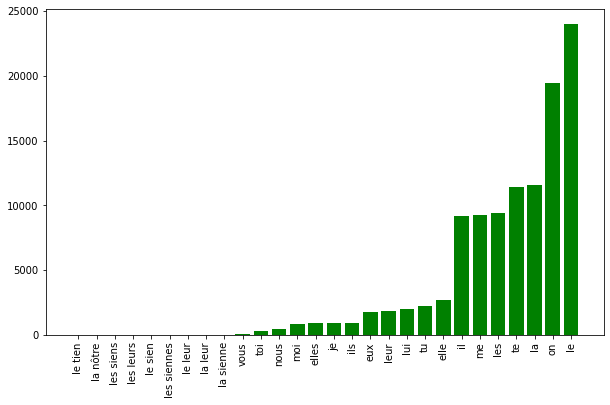

In [256]:
plt.figure(figsize =(10,6))
plt.xticks(rotation=90)
plt.bar(count_plot.keys(), count_plot.values(), color='g')


In [257]:
count_pf = sum([count_plot[k] for k in count_plot.keys() if k in pronom_first])
count_op = sum([count_plot[k] for k in count_plot.keys() if k not in pronom_first])

In [258]:
print('Percentage of first-person pronouns : ' + str((100*count_pf)/(count_pf+count_op)) + '%')

Percentage of first-person pronouns : 10.123844377720788%


## b. Contingency

## c. Project-Back

In [228]:
past = ['VER:subi', 'VER:simp', 'VER:pper', 'VER:impf']

not_pas = ['VER:subp', 'VER:pres','VER:ppre','VER:infi','VER:impe','VER:futu','VER:cond']



In [230]:
df_cond['verb'] = df_cond['tags'].apply(lambda x : [elem for elem in x if (len(elem)>1 and elem[1].startswith('VER'))])


In [ ]:
def count_tense(ls, past = past, not_past = not_pas):
    count = {'past':0, 'else':0}
    for elem in ls:
        if elem[1] in past:
            count['past'] += 1
        else :
            count['else'] +=1
            
    return count

In [234]:
df_cond['verb_past'] = df_cond['verb'].apply(lambda x : sum([1 for elem in x if (len(elem)>1 and elem[1] in past)]))
df_cond['other_verb'] = df_cond['verb'].apply(lambda x : sum([1 for elem in x if (len(elem)>1 and elem[1] in not_pas)]))

In [235]:
print('Number of verbs in past tense : ' + str(df_cond['verb_past'].sum()))
print('Number of verbs not in past tense : ' + str(df_cond['other_verb'].sum()))

Number of verbs in past tense : 22911
Number of verbs not in past tense : 23767


In [236]:
print('Percentage of verbs in past tense : ' + str((100*df_cond['verb_past'].sum())/(df_cond['verb_past'].sum()+df_cond['other_verb'].sum())) + '%')

Percentage of verbs in past tense : 49.083079823471444%


# 12. CamemBERT

In [13]:
import torch
camembert = torch.hub.load('pytorch/fairseq', 'camembert')
camembert.eval()

Using cache found in /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master
2022-03-23 10:30:06 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
fatal: ni ceci ni aucun de ses répertoires parents n'est un dépôt git : .git


running build_ext
cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp


/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (g++) is not compatible with the compiler Pytorch was
built with for this platform, which is clang++ on darwin. Please
use clang++ to to compile your extension. Alternatively, you may
compile PyTorch from source using g++, and then you can also use
g++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
creating /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build
creating /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8
creating /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq
creating /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib
creating /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libbleu
Emitting ninja build file /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/2] c++ -MMD -MF /Users/clemencebarsi/.cache/torch/hub/pytorch_

ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libbleu/libbleu.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libbleu/module.o) was built for newer macOS version (11.0) than being linked (10.9)


Emitting ninja build file /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/1] c++ -MMD -MF /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/data/data_utils_fast.o.d -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/numpy/core/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/numpy/core/include -I/Users/clemencebarsi/miniconda3/include/python3.8 -c -c /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/fairseq/data/data_utils_fast.cpp -o /Users/clemencebarsi/.cache/torch/hub/pytorch_fairse

ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/data/data_utils_fast.o) was built for newer macOS version (11.0) than being linked (10.9)


Emitting ninja build file /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/1] c++ -MMD -MF /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/data/token_block_utils_fast.o.d -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/numpy/core/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/numpy/core/include -I/Users/clemencebarsi/miniconda3/include/python3.8 -c -c /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/fairseq/data/token_block_utils_fast.cpp -o /Users/clemencebarsi/.cache/torch/hub/

ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/data/token_block_utils_fast.o) was built for newer macOS version (11.0) than being linked (10.9)


[1/1] c++ -MMD -MF /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libbase/balanced_assignment.o.d -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/TH -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/THC -I/Users/clemencebarsi/miniconda3/include/python3.8 -c -c /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/fairseq/clib/libbase/balanced_assignment.cpp -o /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libbase/balanced_as

ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libbase/balanced_assignment.o) was built for newer macOS version (11.0) than being linked (10.9)


[1/1] c++ -MMD -MF /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libnat/edit_dist.o.d -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/TH -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/THC -I/Users/clemencebarsi/miniconda3/include/python3.8 -c -c /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/fairseq/clib/libnat/edit_dist.cpp -o /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libnat/edit_dist.o -DTORCH_API_INCLUDE_EX

ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/fairseq/clib/libnat/edit_dist.o) was built for newer macOS version (11.0) than being linked (10.9)


[1/1] c++ -MMD -MF /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/examples/operators/alignment_train_cpu.o.d -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/include -arch x86_64 -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/TH -I/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/torch/include/THC -I/Users/clemencebarsi/miniconda3/include/python3.8 -c -c /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/examples/operators/alignment_train_cpu.cpp -o /Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/examples/operators/alignment_train_c

ld: warning: object file (/Users/clemencebarsi/.cache/torch/hub/pytorch_fairseq_master/build/temp.macosx-10.9-x86_64-3.8/examples/operators/alignment_train_cpu.o) was built for newer macOS version (11.0) than being linked (10.9)
2022-03-23 10:31:29 | INFO | fairseq.file_utils | http://dl.fbaipublicfiles.com/fairseq/models/camembert-base.tar.gz not found in cache, downloading to /var/folders/n1/2dp16v113lv8x5rwt1t69_v40000gn/T/tmpui_d71sl
100%|███████████████████████| 1012630426/1012630426 [01:46<00:00, 9530737.62B/s]
2022-03-23 10:33:15 | INFO | fairseq.file_utils | copying /var/folders/n1/2dp16v113lv8x5rwt1t69_v40000gn/T/tmpui_d71sl to cache at /Users/clemencebarsi/.cache/torch/pytorch_fairseq/3a5b985f6506f03df591fc4564446205fffa6bfe1a5d4657775ed20efdf3162b.4f0d00e7c3a06d48868273ae5e32b16aeb9cafa08939dd691352a8bdae6059be
2022-03-23 10:33:19 | INFO | fairseq.file_utils | creating metadata file for /Users/clemencebarsi/.cache/torch/pytorch_fairseq/3a5b985f6506f03df591fc4564446205fffa6bf

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(32005, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout_module

In [17]:
# Extract the last layer's features
line = "J'aime le camembert !"
tokens = camembert.encode(line)
last_layer_features = camembert.extract_features(tokens)
assert last_layer_features.size() == torch.Size([1, 10, 768])

# Extract all layer's features (layer 0 is the embedding layer)
all_layers = camembert.extract_features(tokens, return_all_hiddens=True)
assert len(all_layers) == 13
assert torch.all(all_layers[-1] == last_layer_features)


# 13. BERTopic

In [108]:
test = df_cond.loc[0]['Eloge_lem']
test

'marin Cureau chambre médecin ordinaire roi naître Mans ord chancelier Séguier attacha habileté médecine étendue variété connaissance confiance ministre fournir chambre moyen utile lettre saisir avidement occasion bien éloigner dédaigner science faire fortune espèce ingratitude malheureusement trop commun cardinal Richelieu donner place Académie français établissement card charger card répondre livre herser faveur prétention cour Rome livre regarder France séditieux ordonner recherche contre auteur chercher asile auprès défendre cause Rome poursuivre inquisition janséniste excommunier point comparaître homme accoutumer regarder devoir zèle montrer intérêt croire aisément dispenser reconnaissance choix cardinal faire Cureau répondre livre herser prouver académicien étudier science bien éloigner physique intituler livre Philalethes ami vérité pareil matière vérité chercher grand bien nation ouvrage physique trouver liste Histoire Académie français absolument oublier contenir découvert re

In [107]:
df_cond['Eloge_lem'] = df_cond['Eloge_lem'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))
df_cond['Eloge_lem'] = df_cond['Eloge_lem'].apply(lambda x : ' '.join([word for word in x.split() if ((word not in fr_stop) and
                                                                      (len(word)>2))]))

In [111]:
df_help = df_cond[[ 'Savant', 'Annee','Eloge', 'Eloge_lem']].copy()

In [113]:
df_help['tags'] = df_help['Eloge_lem'].apply(lambda x : tagger.tag_text(x))

In [115]:
df_help['tags'] = df_help['tags'].apply(lambda x : treetaggerwrapper.make_tags(x))

In [170]:
df_help['nouns'] = df_help['tags'].progress_apply(lambda x : ' '.join([elem[2] for elem in x if(elem[1] =='NOM' or elem[1].startswith('VER'))]))

In [171]:
df_help.head(2)

,Savant,Annee,Eloge,Eloge_lem,tags,nouns
0,de la Chambre,1773,"Marin Cureau de la Chambre, médecin ordinaire ...",marin Cureau chambre médecin ordinaire roi naî...,"[(marin, NOM, marin), (Cureau, NAM, Cureau), (...",marin chambrer médecin roi naître chancelier a...
1,Frenicle,1773,"Nicolas Frenicle de Bessy, conseiller à la cou...",Nicolas Frenicle Bessy conseiller cour monnaie...,"[(Nicolas, NAM, Nicolas), (Frenicle, NAM, Fren...",conseiller cour monnaie trouver nombre magistr...


In [172]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(df_help.nouns, show_progress_bar=True)

In [173]:
from bertopic import BERTopic


# Create topic model
model = BERTopic(language ='French')
topics, probabilities = model.fit_transform(df_help.nouns, embeddings)

In [174]:
#https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

import umap
umap_embeddings = umap.UMAP(n_neighbors=5, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [175]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [176]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_



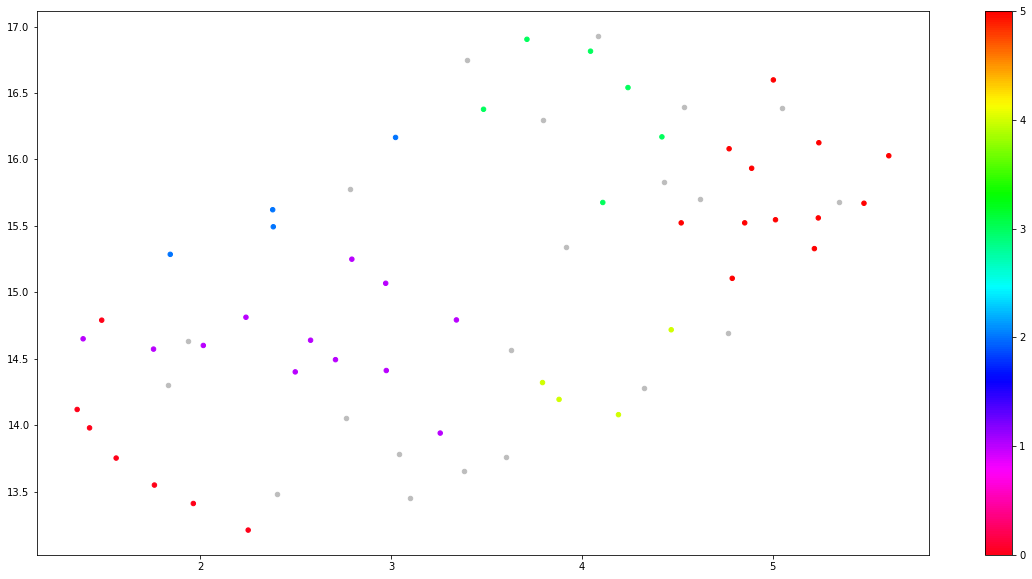

In [177]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=20, cmap='hsv_r')
plt.colorbar()

In [178]:
docs_df = pd.DataFrame(df_help.nouns.tolist(), columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df.head()
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [179]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df_help.nouns))

In [180]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,21
2,1,12
6,5,12
1,0,7
4,3,6
3,2,4
5,4,4


In [181]:
top_n_words[1][:]

[('parallaxe', 0.0011555175018906688),
 ('roëmer', 0.0010981734518454506),
 ('lune', 0.0010480822732462523),
 ('rayon', 0.0010358993503748642),
 ('réfraction', 0.001013698570934262),
 ('jaquier', 0.0009811624026581291),
 ('seur', 0.0009811624026581291),
 ('vergne', 0.0009811624026581291),
 ('soleil', 0.0009526395709898633),
 ('longitude', 0.0009316068576031067),
 ('étoiler', 0.0009316068576031067),
 ('observatoire', 0.000924414001512535),
 ('planeter', 0.0008841466353371669),
 ('distance', 0.0008447488091118851),
 ('direction', 0.0008221498409743221),
 ('cassini', 0.0008166283029583416),
 ('valeur', 0.0008075943781277802),
 ('encyclopédie', 0.000806217133266348),
 ('astronomie', 0.000790043357374078),
 ('latitude', 0.0007849299221265033)]

In [182]:
top_n_words[-1][:]

[('mariotte', 0.0007406107113277032),
 ('peser', 0.0006976264512145079),
 ('irritabilité', 0.0006790529740015736),
 ('équateur', 0.0006775482972802972),
 ('arci', 0.0006682229407088622),
 ('arc', 0.0006629869329075386),
 ('penduler', 0.0006608747054801593),
 ('huygens', 0.0006438019912951135),
 ('colonie', 0.0006170931089871294),
 ('pendule', 0.0006164074113256613),
 ('affinité', 0.0006164074113256613),
 ('électricité', 0.000601746202953759),
 ('vitesse', 0.0005941713522513769),
 ('baromètre', 0.0005852745375410122),
 ('équilibrer', 0.0005760024228657713),
 ('condamine', 0.0005629663340799881),
 ('physiologie', 0.0005571493936278447),
 ('cercler', 0.0005568524505907183),
 ('longueur', 0.0005554580334957775),
 ('bouguer', 0.0005547666701930953)]

In [183]:
top_n_words[5][:]

[('veine', 0.0017265276853469275),
 ('macquer', 0.0017240228763940285),
 ('camper', 0.0016975933151082891),
 ('lassone', 0.0016253641639530053),
 ('pistil', 0.0015092667236706477),
 ('charas', 0.0014040303245449746),
 ('accès', 0.0013426079276888181),
 ('étamine', 0.0013311810789974983),
 ('poussière', 0.0012770718431059328),
 ('foie', 0.0012202493224143735),
 ('veiner', 0.0012164610546307943),
 ('sel', 0.0012118609304324407),
 ('fleur', 0.0011924389385285549),
 ('léthargie', 0.001175966767804566),
 ('viscère', 0.0011303202450029229),
 ('vipère', 0.0010948149491677149),
 ('guettard', 0.0010772215960459888),
 ('sommeil', 0.0010732311885163553),
 ('teinture', 0.0010079715152610568),
 ('fœtus', 0.0009890302143775575)]

In [184]:
top_n_words[3][:]

[('neveu', 0.0031522661029361933),
 ('quinquina', 0.0028074882294433336),
 ('botaniste', 0.002740215598700878),
 ('botanique', 0.0024002955683667376),
 ('germination', 0.002320602442461198),
 ('lac', 0.002320602442461198),
 ('jonc', 0.002320602442461198),
 ('jardin', 0.002144516555505035),
 ('herborisation', 0.0021046249105904917),
 ('fructification', 0.0021046249105904917),
 ('extraction', 0.0021046249105904917),
 ('limer', 0.0021046249105904917),
 ('grainer', 0.0021046249105904917),
 ('retenir', 0.0020366987957510653),
 ('plante', 0.002012722046390946),
 ('contrer', 0.0018889586076400197),
 ('distribution', 0.0018889586076400197),
 ('pierre', 0.0018521597118016928),
 ('insecte', 0.0018466275482184509),
 ('venin', 0.001800221676275053)]

In [185]:
top_n_words[2][:]

[('guise', 0.002591459181299417),
 ('édit', 0.0024658890617817774),
 ('condé', 0.0022219461036857816),
 ('clergé', 0.002058663855495383),
 ('concile', 0.001916617302502336),
 ('bézout', 0.001916617302502336),
 ('vénalité', 0.0019150913523172885),
 ('magistrature', 0.001838094858757392),
 ('réformer', 0.0018151495985912604),
 ('supplice', 0.0017865449506855582),
 ('mécher', 0.0016664595777643363),
 ('pape', 0.0016398816620506443),
 ('violer', 0.0015835875811502948),
 ('dessein', 0.0015835875811502948),
 ('connétable', 0.001578825609494028),
 ('réforme', 0.001578825609494028),
 ('protester', 0.001557017667306258),
 ('déprédation', 0.0015377695208198187),
 ('parlement', 0.0015265027525315762),
 ('intrigue', 0.0014498091042862437)]

In [186]:
top_n_words[4][:]

[('gua', 0.0049632199393706),
 ('administrateur', 0.003194206192142026),
 ('chausser', 0.003026945164431583),
 ('frenicle', 0.0029482318927848824),
 ('loterie', 0.0029482318927848824),
 ('pont', 0.002928711644555916),
 ('département', 0.0021119243317063575),
 ('racine', 0.002041424349067834),
 ('charlatanerie', 0.0019064722283743858),
 ('adhérer', 0.0017233772833441813),
 ('perception', 0.0017233772833441813),
 ('denrée', 0.0016677558171764872),
 ('manufacturer', 0.0016331394792542672),
 ('intendant', 0.0016331394792542672),
 ('subsistance', 0.0015887268569786549),
 ('propriétaire', 0.0015861988706510196),
 ('pauvreté', 0.0015861988706510196),
 ('traduction', 0.0015180374394715324),
 ('commerce', 0.0015166455344999108),
 ('route', 0.0015166455344999108)]

## Octis

https://github.com/MIND-Lab/OCTIS